In [1]:
## imports

import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os
root = os.path.expanduser('~')

company_index='5'
company_name='Amazon'
img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/companies/'+f'{company_index}_{company_name}'
img_flag = False

if not os.path.exists(img_path):
    os.makedirs(img_path)

In [2]:
## making dataset

def get_px_data(company_index=5, company_name='Amazon', uni=False, bi=False, tri=False):
    data_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/data/companies/'+f'{company_index}_{company_name}'+'/output_data/px_data/cons.csv'
    df = pd.read_csv(data_path)
#     print(df.head())
    if uni and bi and tri:
        df_data = df['Unigrams'].fillna('') + ' ' + df['Bigrams'].fillna('') + ' ' + df['Trigrams'].fillna('')
    elif uni:
        df_data = df['Unigrams'].dropna()
    elif bi:
        df_data = df['Bigrams'].dropna()
    elif tri:
        df_data = df['Trigrams'].dropna()
    
    return df_data.tolist()
    
sentences = get_px_data(company_index=company_index, company_name=company_name, 
                        uni=True, bi=True, tri=True)

print(len(sentences))
sentences[:5]

14500


['benefit day driver exhaust manag overwork paid pay season time paid_time ',
 'cold hot insid summer warehous winter  ',
 'break short short_break ',
 'day manag schedul set site  ',
 'dont manag manag_dont ']

In [9]:
def merge_data(company_list=[5], uni=False, bi=False, tri=False):
    sentences = []
    df_company_list = pd.read_csv( root + '/Desktop/workspace/indeed/Job-Satisfaction/data/scraper_data/review_site.csv')
    sentences = []
    for company_index in company_list:
        company_name = df_company_list.iloc[company_index - 1]['Company_Name']
        sentences.extend(get_px_data(company_index=company_index, company_name=company_name, 
                        uni=uni, bi=bi, tri=tri))
    return sentences

sentences = merge_data(company_list=[1],
                        uni=True, bi=True, tri=True)
# sentences = merge_data(company_list=range(1, 51),
#                         uni=True, bi=True, tri=True)
# sentences = merge_data(company_list=[5, 6, 7, 8, 9, 10],
#                         uni=True, bi=True, tri=True)
print(len(sentences))
sentences[:5]

78958


['life walmart  ', 'con  ', 'con  ', 'hour  ', 'hour  ']

In [10]:
## tokenizing

data_px = []
for sent in sentences:
    data_px.append(sent.split())
print(data_px)

[['life', 'walmart'], ['con'], ['con'], ['hour'], ['hour'], ['corpor', 'manag', 'offic', 'store', 'store_manag'], ['benefit', 'check'], ['manag', 'poor', 'store', 'team', 'manag_team'], ['pay'], ['break', 'short', 'short_break'], ['low', 'pay', 'low_pay'], ['manag'], ['peopl'], ['terribl'], ['manag'], ['day', 'sick', 'unfair', 'vacat', 'sick_day'], [], ['break', 'short', 'short_break'], ['commun', 'lack', 'lack_commun'], ['avail', 'manag', 'schedul'], ['discount'], ['bonus', 'discount'], ['manag'], ['break', 'min', 'min_break', '15_min_break'], ['holiday'], ['manag'], ['chang', 'hard'], ['commun', 'differ', 'direct', 'get', 'pull'], ['system'], ['manag'], ['allow', 'cut', 'dont', 'min', 'time', 'unless'], ['day', 'difficult', 'schedul', 'time', 'usual'], ['hour'], ['custom', 'rude', 'treat', 'rude_custom'], ['care', 'cart'], ['schedul'], [], ['black', 'month'], ['break', 'minut', 'short', 'minut_break', 'short_break', '15_minut_break'], ['care', 'health', 'health_care'], ['cultur', 'ho

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_px)
print(len(id2word))
print(id2word)

# Create Corpus
texts = data_px

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1])
print(corpus[:5])

771
Dictionary(771 unique tokens: ['life', 'walmart', 'con', 'hour', 'corpor']...)
[[(0, 1), (1, 1)], [(2, 1)], [(2, 1)], [(3, 1)], [(3, 1)]]


In [12]:
# # Tf-idf model

# tfidf_model = gensim.models.TfidfModel(corpus)
# tfidf_corpus = tfidf_model[corpus]

# corpus = tfidf_corpus

# print(corpus[:5])

In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]]

[[('life', 1), ('walmart', 1)], [('con', 1)], [('con', 1)], [('hour', 1)]]

In [14]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = root + '/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word, iterations=500, 
                                            random_seed=42)

KeyboardInterrupt: 

In [20]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet, texts=data_px, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3968887172841093


In [21]:
##mallet model to lda model conversion

optimal_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.385974  0.018499       1        1  12.981857
4      0.388343  0.002759       2        1  12.755494
2     -0.138358  0.095135       3        1  12.487376
5     -0.089879  0.168043       4        1  12.404696
6     -0.109171 -0.407560       5        1  12.375919
7     -0.147995  0.043222       6        1  12.353979
3     -0.168348  0.175982       7        1  12.321796
0     -0.120565 -0.096079       8        1  12.318883, topic_info=    Category          Freq           Term         Total  loglift  logprob
92   Default   9801.000000       discount   9801.000000  30.0000  30.0000
19   Default  12172.000000          lunch  12172.000000  29.0000  29.0000
0    Default   7510.000000            pay   7510.000000  28.0000  28.0000
35   Default  11228.000000           hour  11228.000000  27.0000  27.0000
16   Default   9377.000000          break   9377.000000  26.0000  26.0000
8    Default   7526.000000        benefit   7526.000000  25.0000  25.0000
50   Default   5726.000000          peopl   5726.000000  24.0000  24.0000
42   Default   6257.000000     hour_lunch   6257.000000  23.0000  23.0000
11   Default   3940.000000           free   3940.000000  22.0000  22.0000
22   Default   3112.000000         custom   3112.000000  21.0000  21.0000
3    Default   3103.000000         cowork   3103.000000  20.0000  20.0000
15   Default   2707.000000           time   2707.000000  19.0000  19.0000
10   Default   2570.000000        employe   2570.000000  18.0000  18.0000
4    Default   2339.000000        flexibl   2339.000000  17.0000  17.0000
182  Default   2500.000000          manag   2500.000000  16.0000  16.0000
7    Default   2305.000000        schedul   2305.000000  15.0000  15.0000
63   Default   2203.000000       friendli   2203.000000  14.0000  14.0000
38   Default   2073.000000    lunch_break   2073.000000  13.0000  13.0000
49   Default   1892.000000        environ   1892.000000  12.0000  12.0000
366  Default   1863.000000           meet   1863.000000  11.0000  11.0000
150  Default   1803.000000         advanc   1803.000000  10.0000  10.0000
31   Default   1777.000000     free_lunch   1777.000000   9.0000   9.0000
30   Default   1710.000000            day   1710.000000   8.0000   8.0000
126  Default   1674.000000           card   1674.000000   7.0000   7.0000
108  Default   1585.000000            fun   1585.000000   6.0000   6.0000
127  Default   1546.000000  discount_card   1546.000000   5.0000   5.0000
9    Default   1495.000000         decent   1495.000000   4.0000   4.0000
96   Default   1384.000000          learn   1384.000000   3.0000   3.0000
170  Default   1771.000000          bonus   1771.000000   2.0000   2.0000
76   Default   1333.000000          minut   1333.000000   1.0000   1.0000
..       ...           ...            ...           ...      ...      ...
368   Topic8     31.326023        process     31.326023   2.0940  -6.8348
366   Topic8   1863.393093           meet   1863.393093   2.0940  -2.7491
352   Topic8    168.756316           cool    168.756316   2.0940  -5.1508
341   Topic8     54.567911          teach     54.567911   2.0940  -6.2798
22    Topic8   3112.391934         custom   3112.391934   2.0940  -2.2361
26    Topic8    237.471462    help_custom    237.471462   2.0940  -4.8092
47    Topic8    125.304091           talk    125.304091   2.0940  -5.4485
51    Topic8    944.833266         experi    944.833266   2.0940  -3.4282
60    Topic8     89.936001   relationship     89.936001   2.0940  -5.7802
96    Topic8   1384.408100          learn   1384.408100   2.0940  -3.0462
112   Topic8    401.175194  custom_servic    401.175194   2.0940  -4.2849
130   Topic8    330.439014     nice_peopl    330.439014   2.0940  -4.4788
50    Topic8   5726.599054          peopl   5726.599054   2.0940  -1.6264
48    Topic8   1052.958570            lot   1058.108283   2.0892  -3.3199
202   Topic8 

In [23]:
img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/companies/LDA_vis'
pyLDAvis.save_html(vis, img_path+'/1-Walmart_pros_500iter_8topics.html')

In [15]:
#parameter tuning (finding the best model)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, 
                                                 iterations=500, random_seed=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [16]:
#  Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_px, start=2, limit=40, step=2)

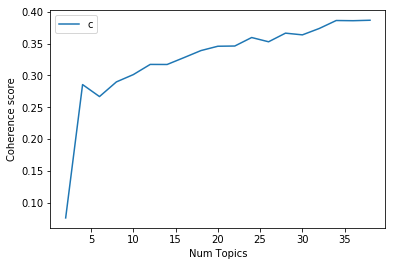

In [17]:
# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [93]:
#  Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_px, start=15, limit=20, step=1)

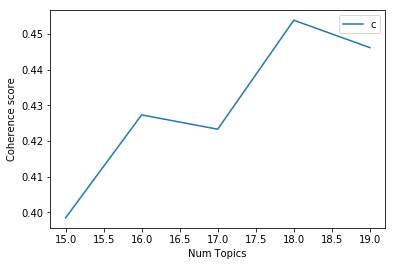

In [94]:
# Show graph
limit=20; start=15; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [18]:
#  Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_px, start=20, limit=25, step=1)

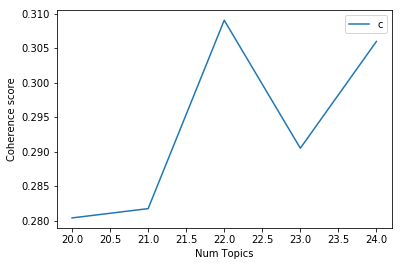

In [22]:
# Show graph
limit=25; start=20; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [18]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2103
Num Topics = 4  has Coherence Value of 0.2722
Num Topics = 6  has Coherence Value of 0.2956
Num Topics = 8  has Coherence Value of 0.3969
Num Topics = 10  has Coherence Value of 0.3907
Num Topics = 12  has Coherence Value of 0.388
Num Topics = 14  has Coherence Value of 0.3867
Num Topics = 16  has Coherence Value of 0.3832
Num Topics = 18  has Coherence Value of 0.3936
Num Topics = 20  has Coherence Value of 0.3686
Num Topics = 22  has Coherence Value of 0.3842
Num Topics = 24  has Coherence Value of 0.3873
Num Topics = 26  has Coherence Value of 0.384
Num Topics = 28  has Coherence Value of 0.3875
Num Topics = 30  has Coherence Value of 0.4096
Num Topics = 32  has Coherence Value of 0.4207
Num Topics = 34  has Coherence Value of 0.4177
Num Topics = 36  has Coherence Value of 0.4091
Num Topics = 38  has Coherence Value of 0.4158


In [438]:
# Selecting the optimal model
optimal_model_ = model_list[12]
optimal_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model_)

In [38]:
# Print the topics
model_topics = optimal_model.show_topics(formatted=True, num_topics=22)
# pprint(optimal_model.print_topics(num_words=10))
pprint(model_topics)

[(0,
  '0.405*"manag" + 0.267*"poor" + 0.132*"poor_manag" + 0.024*"suck" + '
  '0.016*"manag_poor" + 0.014*"poor_pay" + 0.009*"poor_commun" + 0.008*"decis" '
  '+ 0.007*"mobil" + 0.007*"break_poor"'),
 (1,
  '0.667*"hour" + 0.062*"cut" + 0.018*"short_hour" + 0.017*"cut_hour" + '
  '0.015*"vari" + 0.015*"hour_cut" + 0.012*"manag_hour" + 0.012*"hour_time" + '
  '0.012*"time_hour" + 0.012*"hour_manag"'),
 (2,
  '0.332*"break" + 0.312*"short" + 0.274*"short_break" + 0.010*"hand" + '
  '0.009*"break_manag" + 0.006*"short_break_manag" + 0.004*"short_hand" + '
  '0.004*"break_pay" + 0.004*"break_healthcar" + 0.004*"break_benefit"'),
 (3,
  '0.219*"lack" + 0.111*"manag" + 0.097*"train" + 0.092*"commun" + '
  '0.046*"leadership" + 0.041*"support" + 0.028*"associ" + 0.024*"lack_commun" '
  '+ 0.024*"structur" + 0.020*"respect"'),
 (4,
  '0.173*"hard" + 0.067*"move" + 0.050*"polici" + 0.047*"depart" + '
  '0.039*"difficult" + 0.037*"locat" + 0.035*"promot" + 0.034*"strict" + '
  '0.031*"hire" + 0

In [41]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
10      53.777283 -193.445663       1        1  4.661552
2      -23.541248  157.542221       2        1  4.652470
15       2.387278  -21.551226       3        1  4.618736
0       87.194618    3.550050       4        1  4.586847
3       77.998894  155.032303       5        1  4.554866
13    -115.786682  138.275650       6        1  4.547741
8     -262.240723  -57.393333       7        1  4.545646
17    -181.460648  -12.569159       8        1  4.542202
20      78.794533  -81.787361       9        1  4.540349
11     -43.472256 -217.065079      10        1  4.540292
5     -157.875275  -96.186371      11        1  4.530206
9      -77.314270  -41.179348      12        1  4.527414
16    -206.990128   86.546288      13        1  4.524437
21     -76.718124 -129.999435      14        1  4.522602
4      150.268494   74.413841      15        1  4.521707
7      -42.300270   56.120590      16        1  4.521045
12      36.699505   71.746719      17        1  4.520476
14    -157.288940 -191.838074      18        1  4.518735
1     -118.102760   38.770782      19        1  4.516939
18     174.880493  -35.985310      20        1  4.515441
6        1.776131 -110.873199      21        1  4.504619
19     146.182068 -143.292114      22        1  4.485679, topic_info=     Category          Freq          Term         Total  loglift  logprob
5     Default  50474.000000         manag  50474.000000  30.0000  30.0000
3     Default  37466.000000          hour  37466.000000  29.0000  29.0000
15    Default  28193.000000         break  28193.000000  28.0000  28.0000
48    Default  21070.000000          time  21070.000000  27.0000  27.0000
14    Default  22759.000000           pay  22759.000000  26.0000  26.0000
16    Default  22915.000000         short  22915.000000  25.0000  25.0000
17    Default  16877.000000   short_break  16877.000000  24.0000  24.0000
12    Default  11636.000000          poor  11636.000000  23.0000  23.0000
142   Default  10616.000000        advanc  10616.000000  22.0000  22.0000
9     Default  10037.000000       benefit  10037.000000  21.0000  21.0000
18    Default  10042.000000           low  10042.000000  20.0000  20.0000
28    Default   9471.000000          lack   9471.000000  19.0000  19.0000
181   Default   9371.000000        stress   9371.000000  18.0000  18.0000
129   Default   9228.000000       employe   9228.000000  17.0000  17.0000
52    Default   8623.000000        custom   8623.000000  16.0000  16.0000
22    Default   8338.000000           day   8338.000000  15.0000  15.0000
31    Default  10626.000000       schedul  10626.000000  14.0000  14.0000
76    Default   7617.000000           bad   7617.000000  13.0000  13.0000
39    Default   7429.000000          hard   7429.000000  12.0000  12.0000
72    Default   6872.000000        balanc   6872.000000  11.0000  11.0000
94    Default   6402.000000         lunch   6402.000000  10.0000  10.0000
150   Default   5995.000000         shift   5995.000000   9.0000   9.0000
38    Default   5806.000000         chang   5806.000000   8.0000   8.0000
130   Default   5744.000000    poor_manag   5744.000000   7.0000   7.0000
19    Default   5673.000000       low_pay   5673.000000   6.0000   6.0000
0     Default   5439.000000          life   5439.000000   5.0000   5.0000
144   Default   5396.000000       sometim   5396.000000   4.0000   4.0000
224   Default   4904.000000     healthcar   4904.000000   3.0000   3.0000
73    Default   4769.000000       environ   4769.000000   2.0000   2.0000
20    Default   5418.000000         peopl   5418.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
438   Topic22    583.487942         build    584.543542   3.1025  -4.2893
658   Topic22    419.246891      bathroom    419.246891   3.1043  -4.6199
230   Topic22    292.824504          door    292.824504   3.1043  -4.9788

In [40]:
## Dominant Topic in each documents

def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_px):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_px)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.0629,"balanc, life, life_balanc, worklif, worklif_ba...","[life, walmart]"
1,1,19.0,0.0626,"lot, na, con, demand, fast, pace, physic, fast...",[con]
2,2,19.0,0.0626,"lot, na, con, demand, fast, pace, physic, fast...",[con]
3,3,1.0,0.0605,"hour, cut, short_hour, cut_hour, vari, hour_cu...",[hour]
4,4,1.0,0.0606,"hour, cut, short_hour, cut_hour, vari, hour_cu...",[hour]
5,5,20.0,0.0838,"manag, schedul, store, team, upper, inconsist,...","[corpor, manag, offic, store, store_manag]"
6,6,8.0,0.0629,"benefit, healthcar, care, health, dont, insur,...","[benefit, check]"
7,7,20.0,0.1016,"manag, schedul, store, team, upper, inconsist,...","[manag, poor, store, team, manag_team]"
8,8,10.0,0.0609,"pay, low, low_pay, rate, pay_rate, pay_hour, l...",[pay]
9,9,2.0,0.0819,"break, short, short_break, hand, break_manag, ...","[break, short, short_break]"


In [367]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1421,"time, paid, min, vacat, task, senior, start, b...","[break, lunch, min, break_30, min_break, min_l..."
1,0.0,0.1397,"time, paid, min, vacat, task, senior, start, b...","[break, lunch, min, break_30, lunch_break, min..."
2,0.0,0.1374,"time, paid, min, vacat, task, senior, start, b...","[break, lunch, min, stand, walk, break_30, min..."
3,0.0,0.1331,"time, paid, min, vacat, task, senior, start, b...","[break, day, hour, lunch, min, break_30, hour_..."
4,0.0,0.1307,"time, paid, min, vacat, task, senior, start, b...","[break, hr, lunch, min, shift, short, break_30..."


In [368]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts().sort_index()
# display(topic_counts)

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4).sort_index()
# display(topic_contribution)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates().sort_values(by='Dominant_Topic').set_index('Dominant_Topic')
# display(topic_num_keywords)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Topic_Keywords,Num_Documents,Perc_Documents
0.0,"time, paid, min, vacat, task, senior, start, b...",5905,0.1142
1.0,"benefit, healthcar, health, insur, health_insu...",1743,0.0337
2.0,"chang, custom, constant, layoff, rude, constan...",1597,0.0309
3.0,"life, balanc, life_balanc, famili, home, break...",1422,0.0275
4.0,"product, locat, hour, stand, compens, abl, org...",1120,0.0217
5.0,"day, hour, week, sick, hour_day, stand, sit, s...",1342,0.0260
6.0,"break, short, short_break, minut, minut_break,...",417,0.0081
7.0,"shift, hour, system, weekend, holiday, late, n...",1280,0.0248
8.0,"pay, low, low_pay, pay_hour, break_low, pay_lo...",1528,0.0295
9.0,"lot, secur, walk, park, alot, big, temporari, ...",1727,0.0334


In [370]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.0698,"time, paid, min, vacat, task, senior, start, b...","[benefit, day, driver, exhaust, manag, overwor..."
1,1,15.0,0.1331,"hard, littl, pay, move, hot, labor, extrem, wa...","[cold, hot, insid, summer, warehous, winter]"
2,2,18.0,0.0452,"break, short, short_break, music, pick, sleep,...","[break, short, short_break]"
3,3,19.0,0.0631,"schedul, fast, pace, flexibl, slow, fast_pace,...","[day, manag, schedul, set, site]"
4,4,27.0,0.0655,"employe, dont, care, treat, doesnt, free, att,...","[dont, manag, manag_dont]"


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


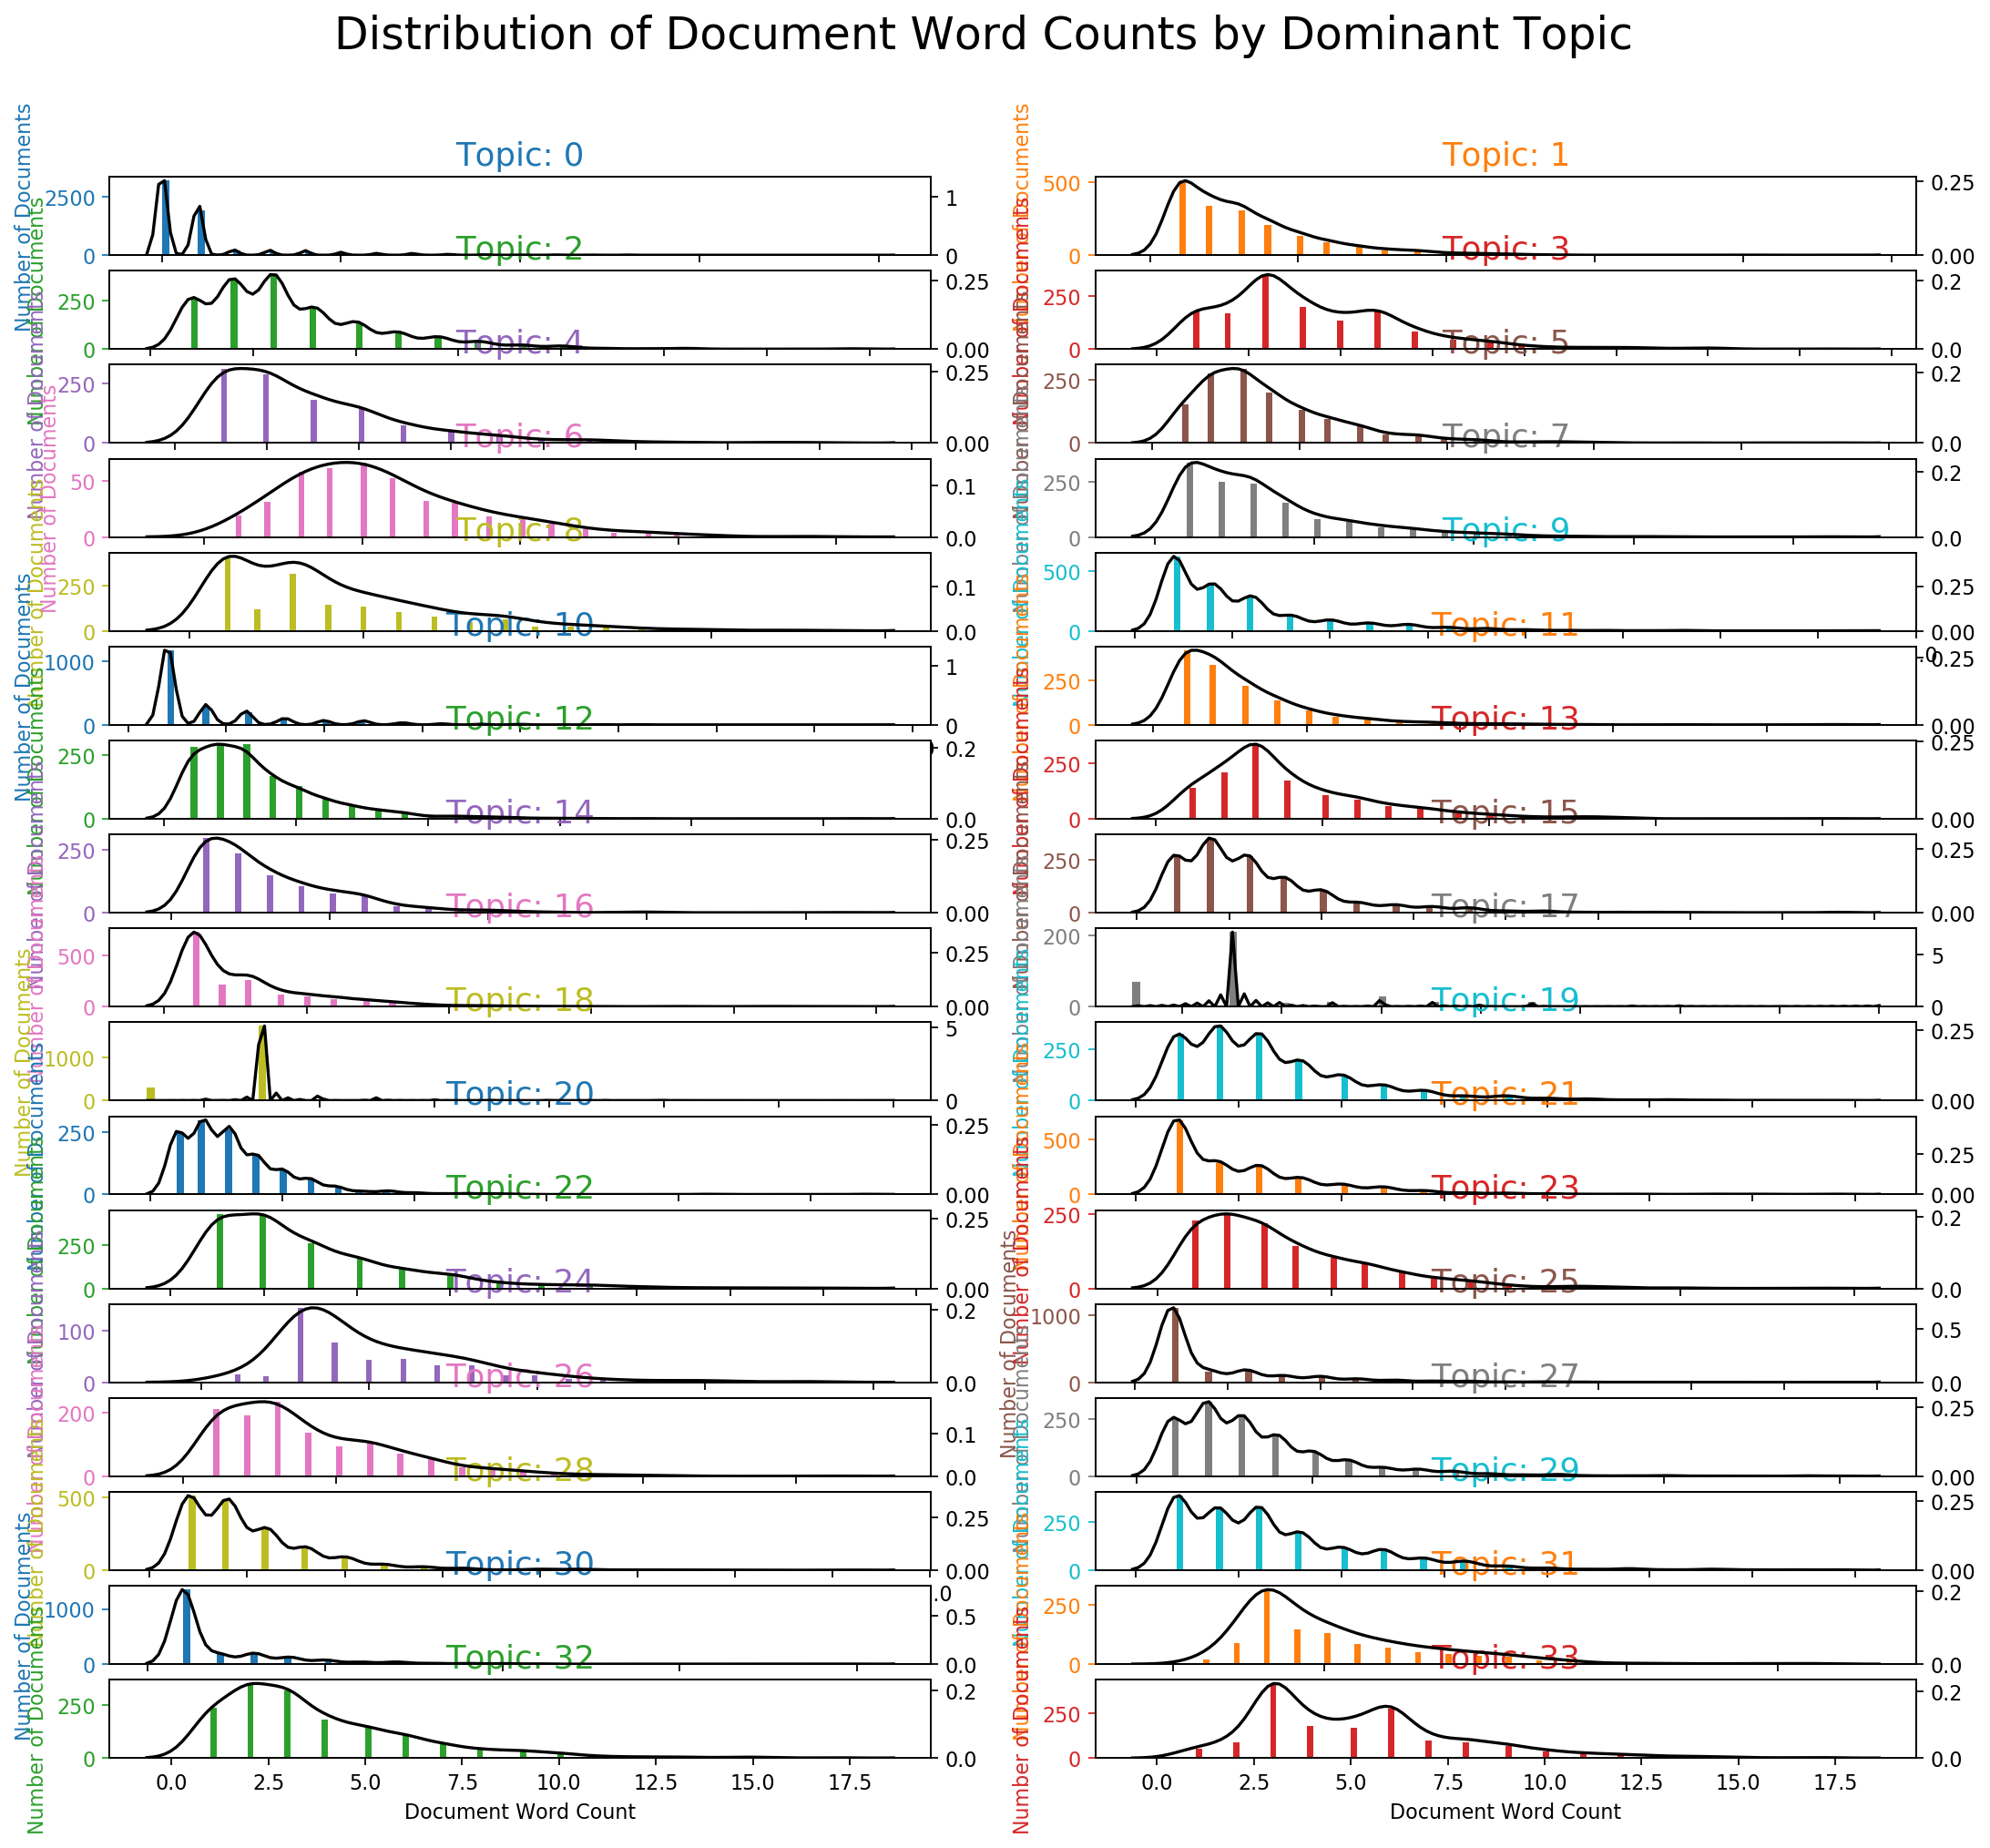

In [376]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(int((optimal_model.num_topics+1)/2),2,figsize=(16,14), dpi=160)

for i, ax in enumerate(axes.flatten()):   
    print(i)
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins=100, color=cols[i%10])
    ax.tick_params(axis='y', labelcolor=cols[i%10], color=cols[i%10])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i%10])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i%10]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
# plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [27]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'apple', 'amazon'])

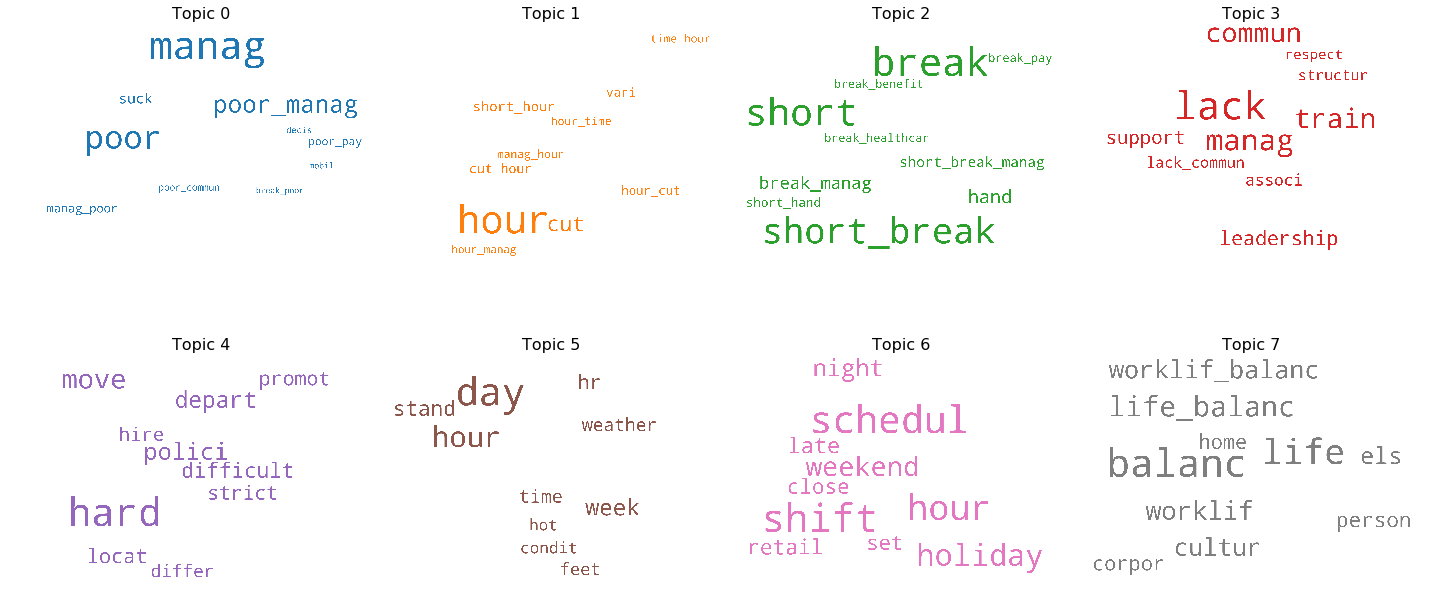

In [30]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=22)
# print(topics)

# for i in range(34):
#     print(topics[i][0])

# print(topics)
fig, axes = plt.subplots(2, 4, figsize=(20,10), sharex=True, sharey=True)


for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(topics[i][0]), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/topics_wc/cons'
img_flag = True

if not os.path.exists(img_path):
    os.makedirs(img_path)
    
if img_flag:
    plt.savefig(img_path+'/1-50-0.png')
    
plt.show()

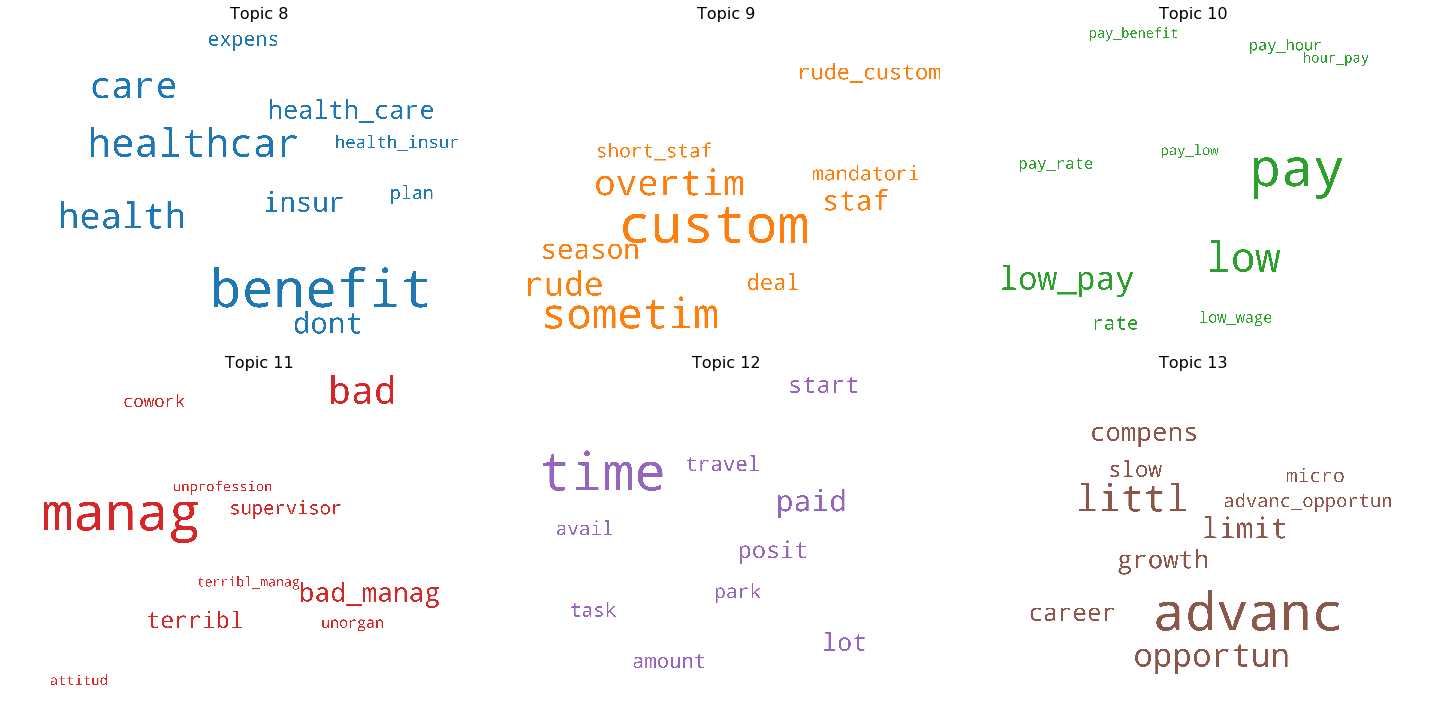

In [32]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=22)
# print(topics)

# print(topics)
fig, axes = plt.subplots(2, 3, figsize=(20,10), sharex=True, sharey=True)


for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i+8][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(topics[i+8][0]), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/topics_wc/cons'
img_flag = True

if not os.path.exists(img_path):
    os.makedirs(img_path)
    
if img_flag:
    plt.savefig(img_path+'/1-50-1.png')
    
plt.show()

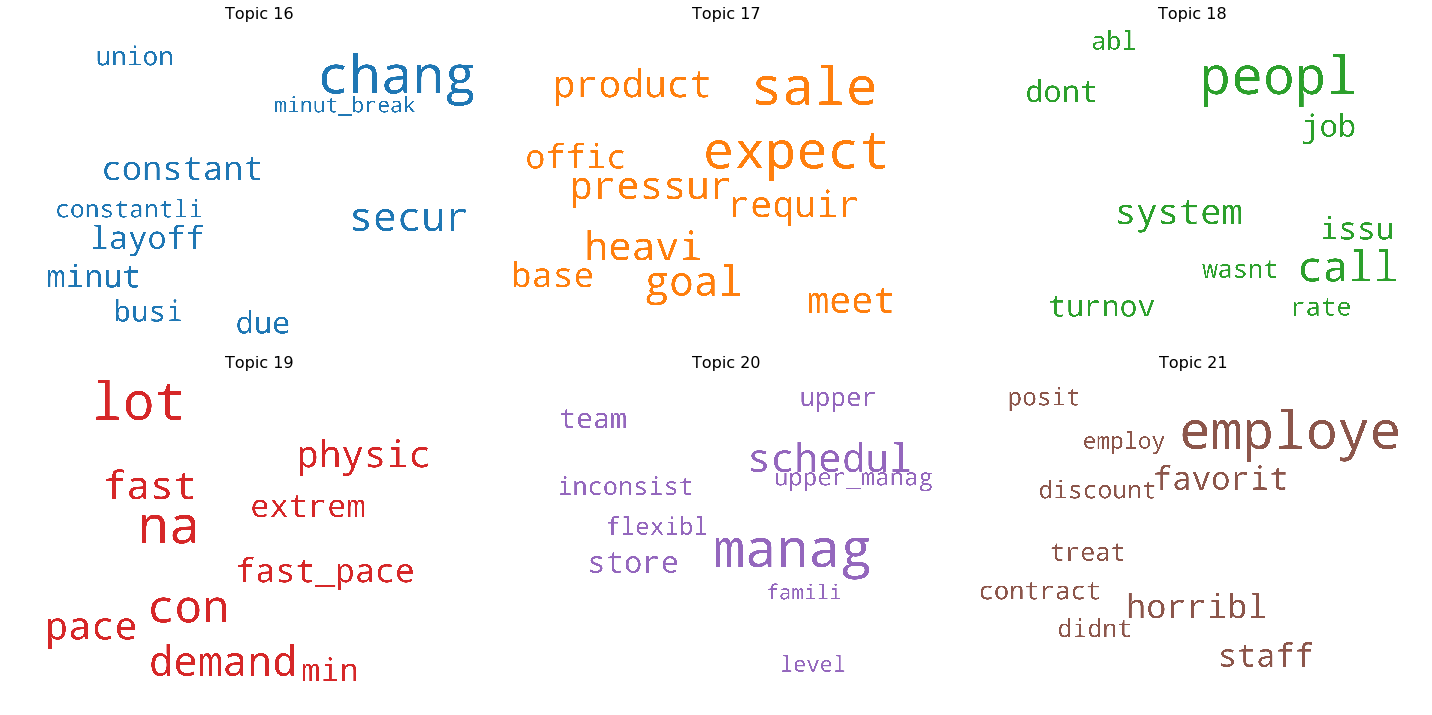

In [34]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=22)
# print(topics)

# print(topics)
fig, axes = plt.subplots(2, 3, figsize=(20,10), sharex=True, sharey=True)


for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i+16][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(topics[i+16][0]), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/topics_wc/cons'
img_flag = True

if not os.path.exists(img_path):
    os.makedirs(img_path)
    
if img_flag:
    plt.savefig(img_path+'/1-50-2.png')
    
plt.show()

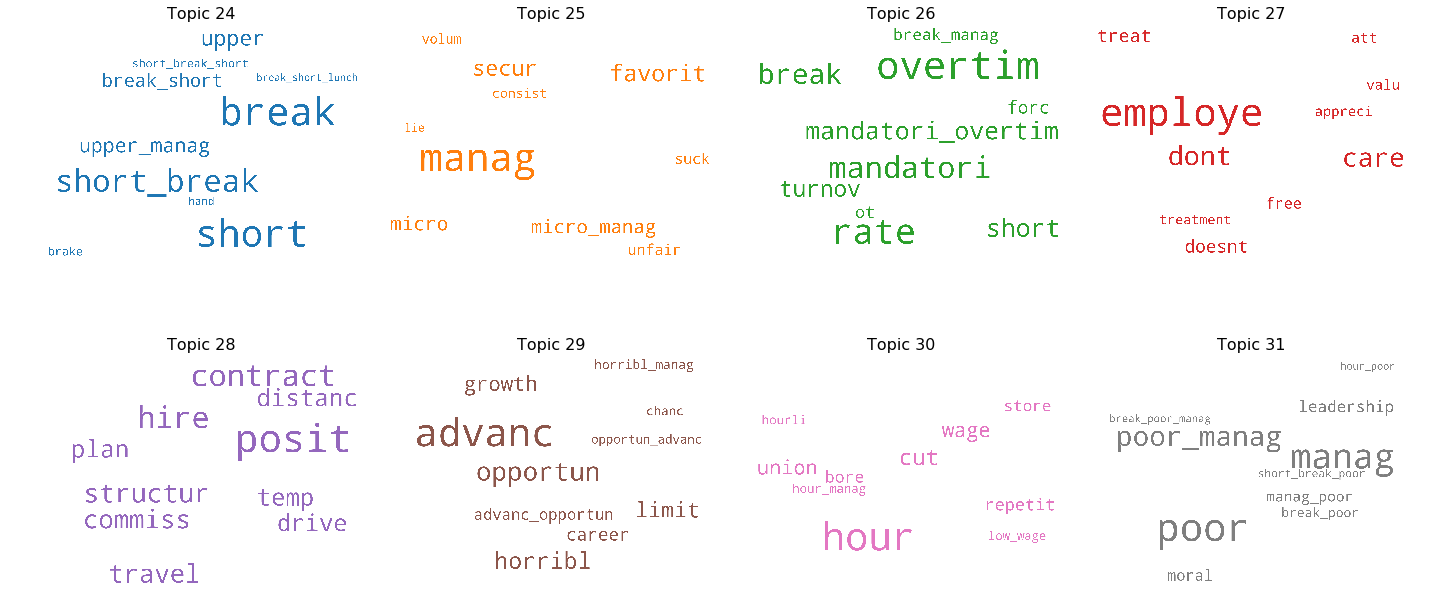

In [415]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=34)
# print(topics)

# print(topics)
fig, axes = plt.subplots(2, 4, figsize=(20,10), sharex=True, sharey=True)


for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i+24][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(topics[i+24][0]), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/topics_wc/cons'
img_flag = True

if not os.path.exists(img_path):
    os.makedirs(img_path)
    
if img_flag:
    plt.savefig(img_path+'/5-10.png')
    
plt.show()

,word,topic_id,importance,word_count
0,time,0,0.159020,2915
1,custom,0,0.052807,968
2,peopl,0,0.040478,755
3,lunch,0,0.030222,1503
4,walk,0,0.022585,414


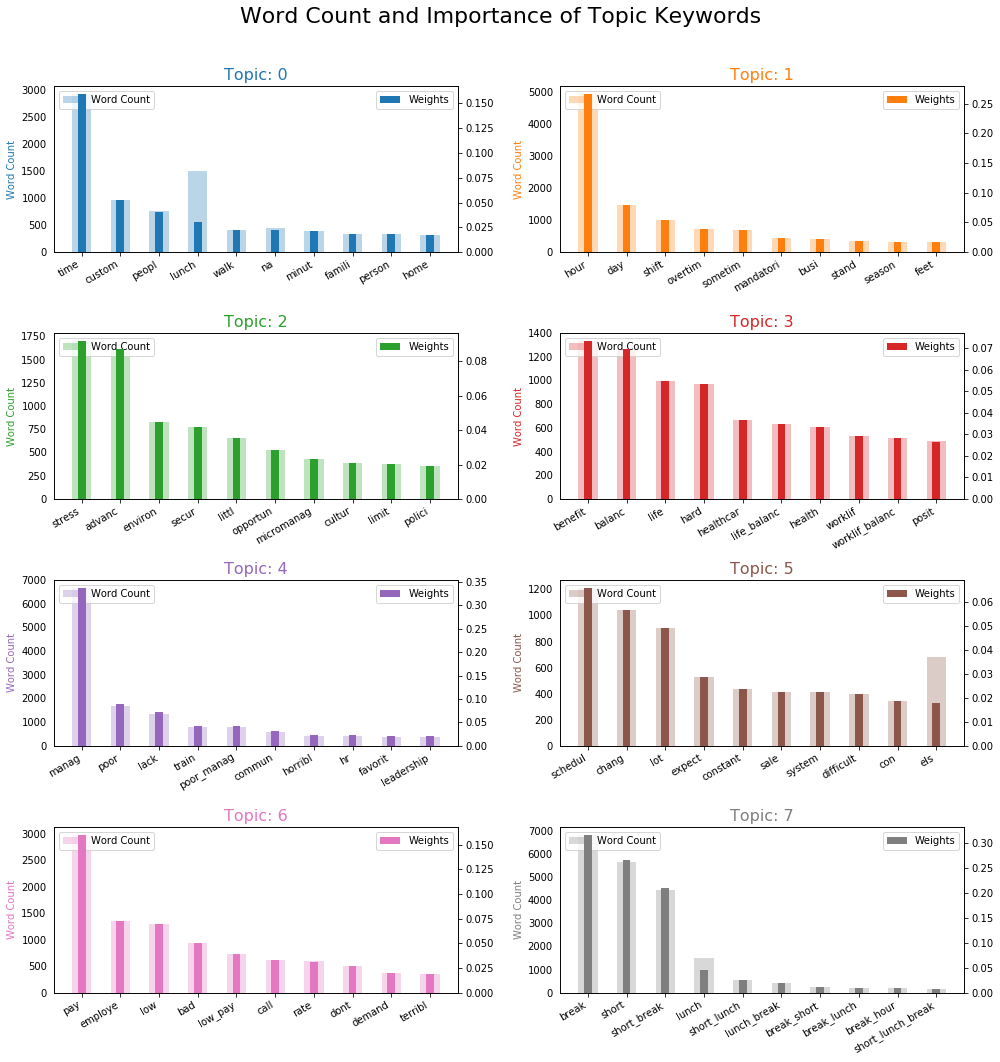

In [349]:
from collections import Counter

topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in data_px for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
display(df.head())
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(int((optimal_model.num_topics+1)/2), 2, figsize=(14,14))
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
#     ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)  

img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/topics_kw/cons'
img_flag = True

if not os.path.exists(img_path):
    os.makedirs(img_path)
    
if img_flag:
    plt.savefig(img_path+'/5-10.png')
    
plt.show()

In [219]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.358148 -0.120103       1        1  12.874436
2      0.211985  0.029961       2        1  12.645177
0     -0.036077  0.210473       3        1  12.562280
1     -0.114077  0.123391       4        1  12.427110
6     -0.127694  0.076265       5        1  12.416472
7     -0.081995 -0.034837       6        1  12.415135
3      0.023139 -0.005252       7        1  12.342520
5     -0.233430 -0.279897       8        1  12.316870, topic_info=    Category         Freq             Term        Total  loglift  logprob
96   Default  2722.000000             fast  2722.000000  30.0000  30.0000
19   Default  2511.000000             pace  2511.000000  29.0000  29.0000
97   Default  2067.000000        fast_pace  2067.000000  28.0000  28.0000
9    Default  2121.000000          environ  2121.000000  27.0000  27.0000
33   Default  3049.000000             hour  3049.000000  26.0000  26.0000
25   Default  3781.000000              day  3781.000000  25.0000  25.0000
269  Default  1561.000000          hardest  1561.000000  24.0000  24.0000
138  Default  2809.000000            enjoy  2809.000000  23.0000  23.0000
39   Default  1489.000000            shift  1489.000000  22.0000  22.0000
116  Default  2726.000000            learn  2726.000000  21.0000  21.0000
185  Default   822.000000             week   822.000000  20.0000  20.0000
0    Default  1777.000000          employe  1777.000000  19.0000  19.0000
212  Default  2016.000000              fun  2016.000000  18.0000  18.0000
133  Default  1184.000000            typic  1184.000000  17.0000  17.0000
3    Default  2141.000000              pay  2141.000000  16.0000  16.0000
15   Default  4976.000000            manag  4976.000000  15.0000  15.0000
285  Default  1094.000000            break  1094.000000  14.0000  14.0000
134  Default  1045.000000        typic_day  1045.000000  13.0000  13.0000
209  Default  1301.000000           custom  1301.000000  12.0000  12.0000
94   Default  1972.000000          benefit  1972.000000  11.0000  11.0000
30   Default  1171.000000           differ  1171.000000  10.0000  10.0000
211  Default   642.000000           packag   642.000000   9.0000   9.0000
127  Default   681.000000             item   681.000000   8.0000   8.0000
378  Default   664.000000        recommend   664.000000   7.0000   7.0000
111  Default  3339.000000            peopl  3339.000000   6.0000   6.0000
72   Default  1697.000000             love  1697.000000   5.0000   5.0000
54   Default   776.000000             pick   776.000000   4.0000   4.0000
194  Default  1149.000000           cowork  1149.000000   3.0000   3.0000
372  Default   784.000000           season   784.000000   2.0000   2.0000
113  Default   858.000000             busi   858.000000   1.0000   1.0000
..       ...          ...              ...          ...      ...      ...
9     Topic8  1991.836266          environ  2121.060535   2.0313  -2.4936
505   Topic8   112.094682      fun_environ   114.197606   2.0756  -5.3711
358   Topic8   315.805209           center   332.769356   2.0419  -4.3353
105   Topic8    58.203008    environ_peopl    59.275670   2.0759  -6.0265
719   Topic8    70.059176       enjoy_fast    72.209240   2.0640  -5.8411
108   Topic8    89.460179  flexibl_schedul    94.762914   2.0366  -5.5966
491   Topic8   140.118352          compani   156.075017   1.9864  -5.1479
313   Topic8   380.475218          overtim   468.271469   1.8866  -4.1490
613   Topic8   122.873016            vacat   140.885693   1.9574  -5.2793
342   Topic8   302.871207         competit   411.861175   1.7868  -4.3771
101   Topic8   378.319551             paid   552.088905   1.7162  -4.1547
92    Topic8   179.998191             fair   242.212581   1.7973  -4.8975
159   Topic8   150.896687      pay_benefit   202.863492   1.7983  -5.0738
589   Topic8   115.328182           polici   152.853781   1.8125  -5.3426
94    Topic8 